<a href="https://colab.research.google.com/github/atran163/Data-301/blob/master/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Research Question: Airbnb Prices in NYC 
NYC is a very diverse area known for its 5 boroughs. These boroughs vary drastically in terms of people, culture, and income. Does Airbnb display these variations through its listings as well? Do prices change from borough to borough and how significant are these changes? Can we also accurately predict prices and make suggestions for houses just like Airbnb does? We will see below in our Data 301 Final Project which is broken up into 3 parts: EDA, Machine Learning, and Final Conclusion. 

## Imports for Data Exploration

In [0]:
# to read the data
import pandas as pd
import numpy as np
import sys
sys.setrecursionlimit(10000000)
import json
from pandas.io.json import json_normalize
import sklearn 
import warnings # the below imports were to stop displaying warnings for aesthetic appeal
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns


# imports specifically for data collection
from folium.plugins import MarkerCluster
import folium
import matplotlib.pyplot as plt

In [0]:
df_bnb = pd.read_csv("listings.csv", error_bad_lines=False, encoding = "utf8")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df = df_bnb.filter(["id", "name", "summary", "space", "description", "host_id", "host_response_rate",
                     "host_is_superhost", "street", "neighbourhood", "city", "latitude", "longitude", 
                     "property_type", "room_type", "bathrooms", "bedrooms", "beds", "bed_type", "amenities", 
                     "square_feet", "price", "cleaning_fee", "number_of_reviews", "review_scores_rating"]) 

In [0]:
df = df[df.price.str.startswith("$", na=False) == True]
df["price_int"] = df["price"].str.replace("$", "").str.replace(",", "").astype(float)

In [0]:
df2["latitude_int"] = df2["latitude"].astype(float)
df2["longitude_int"] = df2["longitude"].astype(float)

In [0]:
subways = json.load(open('ny_subways.json'))
df_json_subway = json_normalize(subways, "data")
df_subway = pd.DataFrame()
df_subway = df_json_subway[11].str.split().apply(pd.Series)
df_subway["longitude"] = df_subway[1].str.replace("(", "")
df_subway["latitude"] = df_subway[2].str.replace(")", "")
del df_subway[0], df_subway[1], df_subway[2]
df_subway["latitude_int"] = df_subway["latitude"].astype(float)
df_subway["longitude_int"] = df_subway["longitude"].astype(float)

## Exploratory Data Analysis

To get a feel for our data...

In [0]:
print("There are",len(df_bnb), "listings in this dataframe.")
print("There are also ", len(df_bnb.columns), "columns in this dataframe.")
print("\n")
print("The columns are:")
for col in df_bnb.columns:
  print(col)

There are 51097 listings in this dataframe.
There are also  106 columns in this dataframe.


The columns are:
id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum

Because we are predicting price, let's look at the distribution of price.

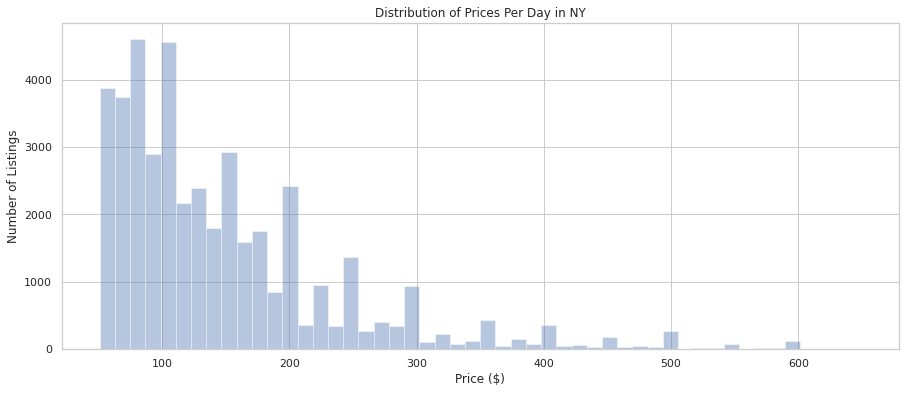

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(15,6))
a = sns.distplot(df2['price_int'], kde=False, 
             axlabel = "Price ($)")
a.set_title("Distribution of Prices Per Day in NY")
a.set_ylabel("Number of Listings")
pass # we wanted to get rid of the <....matplotlib...> 

*  Interpretation: Our data is heavily skewed to the right where majority of listings are between 50-200 dollars a night. This doesn't give us the big picture however because prices can be normally distributed within a borough.


There are 5 core boroughs in New York and over 200 neighborhoods. This data didn't have listings categorized by borough so we will do it manually by joining another dataset which has 2 columns, "neighborhood" and "borough" and we will match "neighborhood" on our dataset to get the "borough" information.

In [0]:
joined = pd.read_csv("neighbourhoods.csv")  # another CSV file to join on 
df = df.merge(joined, on=["neighbourhood"])
df = df.rename(columns={"neighbourhood_group": "boroughs"}) # renaming the column

Now we can finally look at the distribution of price by borough. We are limiting price to be within 50-650 dollars a night because we had many outlier values.

In [0]:
df2 = df[df.price_int < 650]
df2 = df2[df2.price_int > 50]

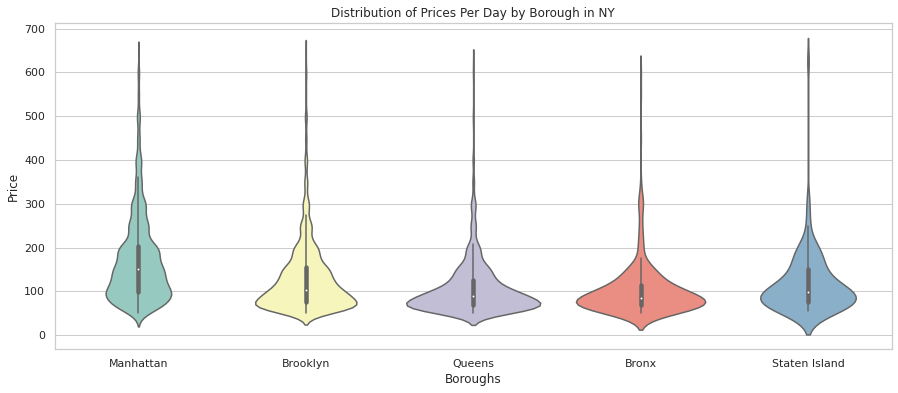

In [0]:
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
ax = sns.violinplot(x="boroughs", y="price_int",
                 data=df2, palette="Set3")
ax.set_title("Distribution of Prices Per Day by Borough in NY")
ax.set_ylabel("Price")
ax.set_xlabel("Boroughs")
pass # we wanted to get rid of the <....matplotlib...> 

*   Interpretation: The violin plots show that for for every borough except Manhattan the majority of the air bnb prices are right under $100 a night. Brooklyn and Staten Island have a little more variability in price in that the wings of the violin plot are not as wide as the wings we see in the Queens and the Bronx plots. Whereas with Manhattan there is a lot of variability throughout all prices where there is a good spread of prices per night between rooms that cost between 100 dollars - 300 dollars a night.



Another variable to consider in this dataset is room type. Room type directly affects price as the number of rooms increases, the price increases as well. Let's look at the distribution of room type in each borough

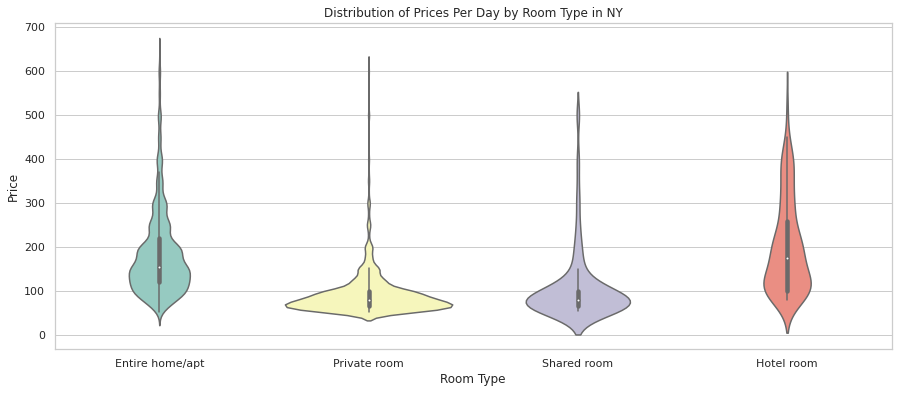

In [0]:
plt.figure(figsize=(15,6))
sns.set(style="whitegrid")
ax = sns.violinplot(x="room_type", y="price_int",
                 data=df2, palette="Set3")
ax.set_title("Distribution of Prices Per Day by Room Type in NY")
ax.set_ylabel("Price")
ax.set_xlabel("Room Type")
pass # we wanted to get rid of the <....matplotlib...> 

*   Interpretation: The violin plot shows that both private room and shared rooms have very little variability in the prices per room type. Most of the values of the room appear to be right under 100 dollars per night. However with entire home/apartments or hotel rooms there is much more variability in the cost per night with entire homes having a large cluster of prices between 100- 300 dollars and hotels having a great spreat of prices.


What's an EDA of New York Airbnb's without a map?

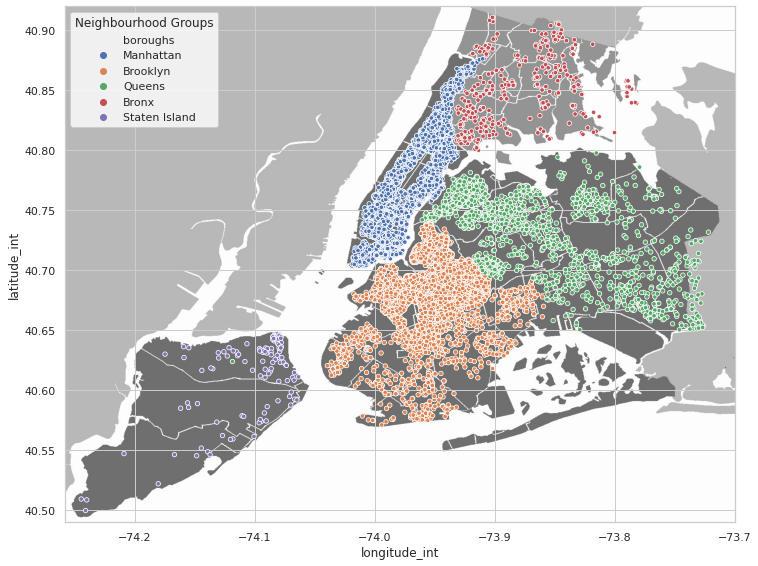

In [0]:
df2["latitude_int"] = df2["latitude"].astype(float)
df2["longitude_int"] = df2["longitude"].astype(float)
fig, ax = plt.subplots(figsize=(12,12))

# Show Background image
img=plt.imread('New_York_City_.png', 0)
coordenates_to_extent = [-74.258, -73.7, 40.49, 40.92]
ax.imshow(img, zorder=0, extent=coordenates_to_extent)


# Plotting
scatter_map = sns.scatterplot(x='longitude_int', y='latitude_int', hue='boroughs',s=20, ax=ax, data=df2)
ax.grid(True)
plt.legend(title='Neighbourhood Groups')
plt.show()

Where are the most expensive listings? Let's make an interactive map which shows where the listings whose price is over 650 dollars a night are.

In [0]:
df_expensive = df[df.price_int > 650] #create another DF with just expensive homes
df_expensive["latitude_int"] = df_expensive["latitude"].astype(float)
df_expensive["longitude_int"] = df_expensive["longitude"].astype(float)

In [0]:
# Using folium to create this interactive map
location_ny = [40.7128, -74.0060] 
map_ny = folium.Map(location=(location_ny), zoom_start=12)
mc = MarkerCluster()
MAX_RECORDS = 1000

#creating a marker for each point in the df
for lat,lon in zip(df_expensive.latitude_int, df_expensive.longitude_int):
    mc.add_child(folium.Marker(location=[lat, lon]))
 
map_ny.add_child(mc)
map_ny





*   Interpretation: As we can see, our our most expensive airbnbs lie in Manhattan like our violin plots showed





Finally, we wanted to combine our Airbnb data with data on the subway stations. Let's plot the subway stations in New York and see if the extremely expensive Airbnb's lie near the subway stations. An extremely expensive listing is over 2000 dollars a night. Again, our subway station location data came from our JSON file from NYC Open Data

In [0]:
#Plot the Most Expensive Airbnb's Where Price > 2000
df_expensive2 = df[df.price_int > 2000]
df_expensive2["latitude_int"] = df_expensive2["latitude"].astype(float)
df_expensive2["longitude_int"] = df_expensive2["longitude"].astype(float)

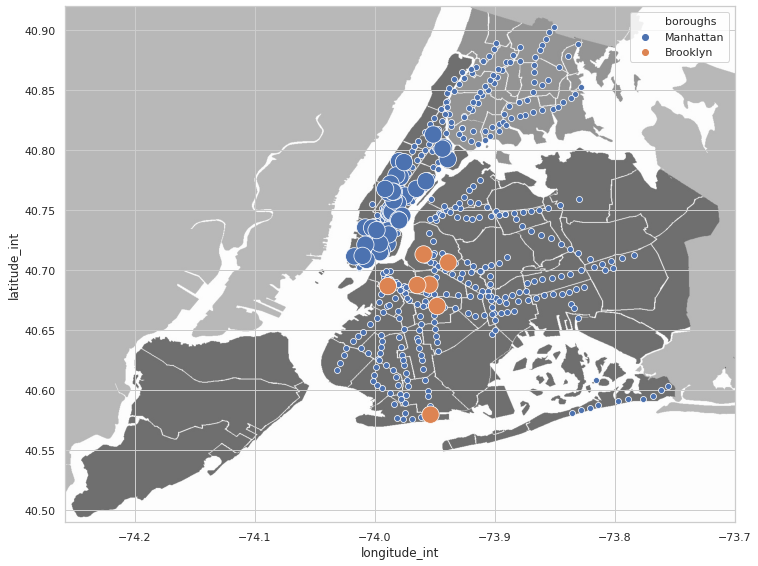

In [0]:
fig, ax = plt.subplots(figsize=(12,12))

# Show Background image
img=plt.imread('New_York_City_.png', 0)
coordenates_to_extent = [-74.258, -73.7, 40.49, 40.92]
ax.imshow(img, zorder=0, extent=coordenates_to_extent)


# # Plotting
sns.scatterplot(x='longitude_int', y='latitude_int', data=df_subway)
scatter_map = sns.scatterplot(x='longitude_int', y='latitude_int', hue='boroughs',s=300, ax=ax, data=df_expensive2)



*   Interpretation: Our most expensive Airbnb's are only in Manhattan and Brooklyn. We hypothesized that the most expensive Airbnb's would be near a subway station, but we didn't realize just how many subway stations there are in New York. Thus, it is pretty hard not to be close to a subway station. Regardless, we still thought it was fun to play with the JSON file.

